In [1]:
# Adjustable
N = 10 # number of predictors selected
tolerance = 0.5 # plus or minus from exact accuracy
random = 42

Top 10 predictors

In [2]:
import pandas as pd
from scipy import stats
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.decomposition import PCA

# Load the CSV data
data = pd.read_csv(r'C:\Users\phili\Downloads\BodyFat.csv') # copy to path from files folder
data = data[data['BODYFAT'] != 0]

# Exclude 'DENSITY' from the DataFrame
# data = data.drop('DENSITY', axis=1)

# Perform ANOVA for each predictor variable
target_variable = 'BODYFAT'
alpha = 0.05
significant_predictors_anova = []

for predictor_variable in data.columns:
    if predictor_variable != target_variable and predictor_variable != "IDNO":
        anova_result = stats.f_oneway(data[predictor_variable], data[target_variable])

        # Check the p-value and add the predictor variable to the list of significant predictors if p-value is less than alpha
        if anova_result.pvalue < alpha:
            significant_predictors_anova.append(predictor_variable)

# Method 1: Correlation Analysis
correlation_matrix = data.corr()
correlation_with_target = correlation_matrix['BODYFAT'].abs().sort_values(ascending=False)
correlation_predictors = correlation_with_target[1:N+1].index.tolist()

# Method 2: RFE
model = LinearRegression()
rfe = RFE(estimator=model, n_features_to_select=N)
X = data.drop('BODYFAT', axis=1)
y = data['BODYFAT']
rfe.fit(X, y)
rfe_predictors = X.columns[rfe.support_].tolist()

# Method 3: Feature Importance (Random Forest)
model = RandomForestRegressor(n_estimators=100, random_state=random)
X = data.drop('BODYFAT', axis=1)
y = data['BODYFAT']
model.fit(X, y)
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
feature_importance_predictors = feature_importances.nlargest(N).index.tolist()

# Method 4: Lasso
alpha = 0.01  # Adjust as needed
lasso = Lasso(alpha=alpha)
X = data.drop('BODYFAT', axis=1)
y = data['BODYFAT']
lasso.fit(X, y)
lasso_predictors = X.columns[lasso.coef_ != 0].tolist()

# Method 5: PCA (Principal Component Analysis)
pca = PCA(n_components=N)
X = data.drop('BODYFAT', axis=1)
y = data['BODYFAT']
X_pca = pca.fit_transform(X)
pca_predictors = [f'PCA_{i+1}' for i in range(N)]

# Combine selected predictors from all methods
all_selected_predictors = (
    correlation_predictors +
    rfe_predictors +
    feature_importance_predictors +
    lasso_predictors +
    pca_predictors +
    significant_predictors_anova
)

# Count the occurrences of each predictor and select the top 10
top_10_predictors = pd.Series(all_selected_predictors).value_counts().head(N).index.tolist()

print(f"Overall Top 10 Predictors: {top_10_predictors}")

Overall Top 10 Predictors: ['KNEE', 'ADIPOSITY', 'DENSITY', 'CHEST', 'ABDOMEN', 'HIP', 'WEIGHT', 'NECK', 'BICEPS', 'WRIST']


Z-Score Outliers

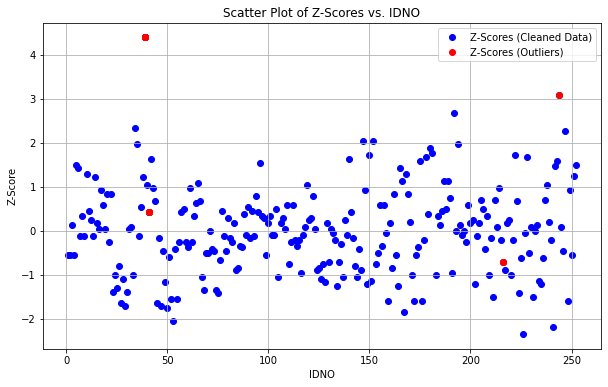

Outliers are located at: [ 39  41 216 244]


In [3]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

X = data[top_10_predictors]

# Calculate z-scores for the top 10 predictors
scaler = StandardScaler()
z_scores = scaler.fit_transform(X)

# Define a threshold for identifying outliers (e.g., z-score > 3)
outlier_threshold = 3

# Identify and remove outliers
outlier_indices_z = np.where(np.abs(z_scores) > outlier_threshold)
outlier_IDNO_z = np.unique(data.iloc[outlier_indices_z[0]]['IDNO'])

# Create a scatter plot of the z-scores vs. IDNO
plt.figure(figsize=(N, 6))

# Plot the z-scores on the y-axis and 'IDNO' on the x-axis for cleaned data in blue
plt.scatter(data['IDNO'], z_scores[:, 0], c='b', label='Z-Scores (Cleaned Data)')

# Plot the z-scores on the y-axis and 'IDNO' on the x-axis for outliers in red
plt.scatter(data.iloc[outlier_indices_z[0]]['IDNO'], z_scores[outlier_indices_z[0], 0], c='r', label='Z-Scores (Outliers)')

plt.xlabel('IDNO')
plt.ylabel('Z-Score')
plt.title('Scatter Plot of Z-Scores vs. IDNO')
plt.legend()
plt.grid(True)
plt.show()
print(f"Outliers are located at: {outlier_IDNO_z}")

DFBETA Outliers

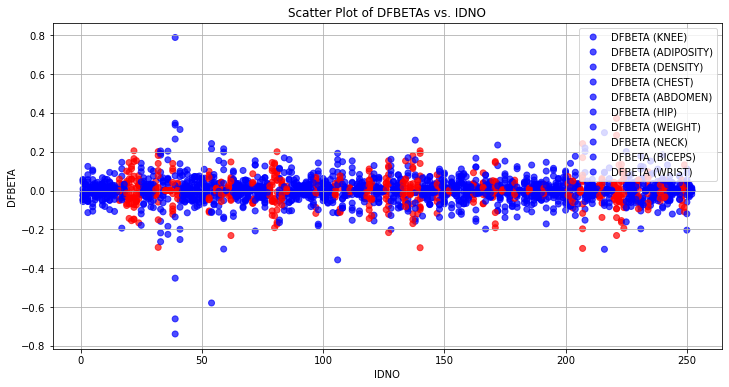

Outliers are located at: [ 17  20  21  22  23  24  25  32  33  36  38  39  41  54  57  59  62  63
  72  79  80  81  82  84  86  98 106 108 112 119 120 121 127 128 134 135
 137 138 140 141 148 153 163 167 171 172 175 180 186 192 202 204 207 208
 215 216 221 222 223 224 225 231 235 240 242 249 250]


In [4]:
import statsmodels.api as sm

# Fit an ordinary least squares (OLS) regression model
model = sm.OLS(data['BODYFAT'], X).fit()

# Calculate DFBETAs for each predictor and each observation
dfbetas = model.get_influence().dfbetas

# Calculate a threshold for identifying influential observations
influential_threshold = 2 / np.sqrt(len(data))

# Identify the influential observations based on DFBETAs
influential_observations = np.where(np.abs(dfbetas) > influential_threshold)

# Get the 'IDNO' values for influential observations
influential_IDNO = data.iloc[influential_observations[0]]['IDNO']
outlier_IDNO_dfbeta = data.iloc[influential_observations[0]]['IDNO']

# Create a list to store colors for each observation
colors = ['r' if i in influential_IDNO else 'b' for i in data['IDNO']]

# Create a scatter plot of DFBETAs vs. 'IDNO' with outliers in red and non-outliers in blue
plt.figure(figsize=(12, 6))

# Loop through each predictor and create scatter plots
for i, variable in enumerate(top_10_predictors):
    plt.scatter(data['IDNO'], dfbetas[:, i], c=colors, label=f'DFBETA ({variable})', alpha=0.7)

plt.xlabel('IDNO')
plt.ylabel('DFBETA')
plt.title('Scatter Plot of DFBETAs vs. IDNO')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()
print(f"Outliers are located at: {np.unique(outlier_IDNO_dfbeta)}")

Cook's Distance Outliers and VIF

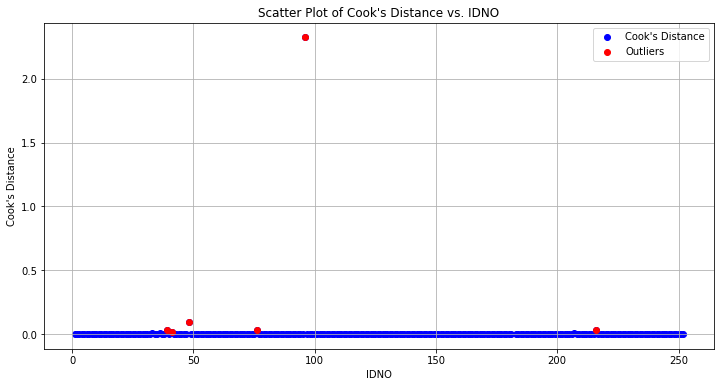

Outliers are located at: [ 39  41  48  76  96 216]


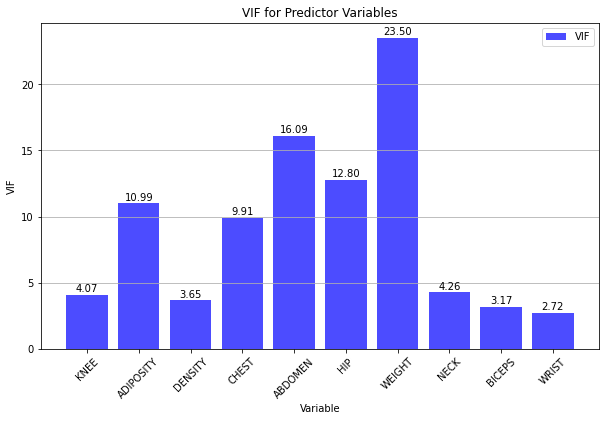

In [5]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Select the predictor columns (top_10_predictors) you want to use
X = data[top_10_predictors]

# Calculate Cook's distance for each data point
X = sm.add_constant(X)
model = sm.OLS(data['BODYFAT'], X).fit()
influence = model.get_influence()
cooks_distance = influence.cooks_distance[0]

# Calculate VIF for each predictor
vif = pd.DataFrame()
vif_threshold = 5.0
vif["Variable"] = X.columns[1:]  # Exclude the constant term
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(1, X.shape[1])]

# Define a threshold for identifying outliers based on Cook's distance
cook_threshold = 4 / len(data)

# Identify the outliers based on Cook's distance
outlier_indices_cook = np.where(cooks_distance > cook_threshold)
outlier_IDNO_cook = np.unique(data.iloc[outlier_indices_cook[0]]['IDNO'])

# Create a scatter plot of Cook's distance vs. 'IDNO'
plt.figure(figsize=(12, 6))

# Plot Cook's distance on the y-axis and 'IDNO' on the x-axis for all data points in blue
plt.scatter(data['IDNO'], cooks_distance, c='b', label="Cook's Distance")

# Highlight the outliers in red
plt.scatter(data.iloc[outlier_indices_cook]['IDNO'], cooks_distance[outlier_indices_cook], c='r', label='Outliers')

plt.xlabel('IDNO')
plt.ylabel("Cook's Distance")
plt.title("Scatter Plot of Cook's Distance vs. IDNO")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()
print(f"Outliers are located at: {outlier_IDNO_cook}")

# Create a bar plot of VIF for all 10 variables with values displayed
plt.figure(figsize=(N, 6))

# Plot VIF values on the y-axis and 'Variable' on the x-axis
plt.bar(vif["Variable"], vif["VIF"], color='b', alpha=0.7, label="VIF")

# Display the VIF values on top of the bars
for index, value in enumerate(vif["VIF"]):
    plt.text(index, value + 0.1, f'{value:.2f}', ha='center', va='bottom')

plt.xlabel('Variable')
plt.ylabel('VIF')
plt.title('VIF for Predictor Variables')
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis='y')
plt.show()

New Data without Outliers

In [6]:
# Identify 'IDNO' values that are outliers in z-scores, Cook's distance, and DFBETA
common_outliers = set(outlier_IDNO_z).intersection(outlier_IDNO_cook, np.unique(outlier_IDNO_dfbeta))

# Create a new DataFrame 'cleaned_data' by removing rows with common outliers
cleaned_data = data[~data['IDNO'].isin(common_outliers)]

Identify Outliers

In [7]:
common_outliers_list = list(common_outliers)
print("IDNO values of common outliers:", common_outliers_list)

IDNO values of common outliers: [216, 41, 39]


Models

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# Select the top 10 predictors
X = cleaned_data[top_10_predictors]
y = cleaned_data['BODYFAT']

# Split the data into training, validation, and test sets with a 60/20/20 split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.6, random_state=random)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=random)

# Multivariable Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_validation)

# Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=random)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_validation)

# Create and train the SVR model
svr_model = SVR(kernel='linear')  # You can change the kernel as needed (e.g., 'linear', 'rbf')
svr_model.fit(X_train, y_train)
y_pred_svr = svr_model.predict(X_validation)

# Define a custom accuracy metric with a tolerance
def custom_accuracy(y_true, y_pred, tolerance=tolerance):
    accurate_predictions = np.abs(y_true - y_pred) <= tolerance
    accuracy = np.mean(accurate_predictions)
    return accuracy

# Calculate and display metrics for Linear Regression
mse_linear = mean_squared_error(y_validation, y_pred_linear)
rmse_linear = np.sqrt(mse_linear)
r2_linear = r2_score(y_validation, y_pred_linear)
wmape_linear = (np.abs((y_validation - y_pred_linear) / y_validation) * 100).mean()

# Calculate and display metrics for Random Forest Regressor
mse_rf = mean_squared_error(y_validation, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_validation, y_pred_rf)
wmape_rf = (np.abs((y_validation - y_pred_rf) / y_validation) * 100).mean()

# Calculate and display metrics for Support Vector Regressor
mse_svr = mean_squared_error(y_validation, y_pred_svr)
rmse_svr = np.sqrt(mse_svr)
r2_svr = r2_score(y_validation, y_pred_svr)
wmape_svr = (np.abs((y_validation - y_pred_svr) / y_validation) * 100).mean()

# Display the metrics for each model on the validation set
print("Metrics on Validation Set:")
print("Linear Regression:")
print(f"Custom Accuracy (Tolerance: {tolerance} units up or down): {custom_accuracy(y_validation, y_pred_linear) * 100:.2f}%")
print(f"RMSE: {rmse_linear:.2f}")
print(f"R-squared (R^2): {r2_linear:.2f}")
print(f"WMAPE: {wmape_linear:.2f}%")

print("\nRandom Forest Regressor:")
print(f"Custom Accuracy (Tolerance: {tolerance} units up or down): {custom_accuracy(y_validation, y_pred_rf) * 100:.2f}%")
print(f"RMSE: {rmse_rf:.2f}")
print(f"R-squared (R^2): {r2_rf:.2f}")
print(f"WMAPE: {wmape_rf:.2f}%")

print("\nSupport Vector Regressor:")
print(f"Custom Accuracy (Tolerance: {tolerance} units up or down): {custom_accuracy(y_validation, y_pred_svr) * 100:.2f}%")
print(f"RMSE: {rmse_svr:.2f}")
print(f"R-squared (R^2): {r2_svr:.2f}")
print(f"WMAPE: {wmape_svr:.2f}%")

# Evaluate the best model on the test set
best_model = None  # Replace with the best model (e.g., based on validation performance)
if best_model is not None:
    y_pred_test = best_model.predict(X_test)
    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mse_test)
    r2_test = r2_score(y_test, y_pred_test)
    wmape_test = (np.abs((y_test - y_pred_test) / y_test) * 100).mean()

    print("\nMetrics on Test Set:")
    print(f"RMSE: {rmse_test:.2f}")
    print(f"R-squared (R^2): {r2_test:.2f}")
    print(f"WMAPE: {wmape_test:.2f}%")

Metrics on Validation Set:
Linear Regression:
Custom Accuracy (Tolerance: 0.5 units up or down): 95.95%
RMSE: 0.50
R-squared (R^2): 1.00
WMAPE: 1.31%

Random Forest Regressor:
Custom Accuracy (Tolerance: 0.5 units up or down): 89.19%
RMSE: 0.80
R-squared (R^2): 0.99
WMAPE: 2.09%

Support Vector Regressor:
Custom Accuracy (Tolerance: 0.5 units up or down): 4.05%
RMSE: 4.61
R-squared (R^2): 0.60
WMAPE: 21.83%


Key Coefficients

In [9]:
# Access the coefficients of the Linear Regression model
coefficients = linear_model.coef_

# Print the coefficients for each predictor variable
for i, predictor in enumerate(top_10_predictors):
    print(f"{predictor}: {coefficients[i]:.4f}")

# Intercept
intercept = linear_model.intercept_
print(f"Intercept: {intercept:.4f}")


KNEE: -0.0155
ADIPOSITY: 0.0223
DENSITY: -410.5494
CHEST: 0.0008
ABDOMEN: -0.0001
HIP: 0.0018
WEIGHT: 0.0005
NECK: 0.0020
BICEPS: -0.0254
WRIST: 0.0021
Intercept: 452.6531


Significance Tests

In [10]:
from scipy.stats import wilcoxon

# Perform Wilcoxon signed-rank tests to compare coefficients of all three models
linear_coeffs = linear_model.coef_
rf_coeffs = rf_model.feature_importances_
svr_coeffs = svr_model.coef_[0]  # Extract coefficients from SVR

# Initialize lists to store the differences in coefficients
differences_linear_rf = []
differences_linear_svr = []
differences_rf_svr = []

# Iterate through predictors and calculate differences in coefficients for each pair of models
for i in range(len(linear_coeffs)):
    difference_linear_rf = linear_coeffs[i] - rf_coeffs[i]
    difference_linear_svr = linear_coeffs[i] - svr_coeffs[i]
    difference_rf_svr = rf_coeffs[i] - svr_coeffs[i]
    
    differences_linear_rf.append(difference_linear_rf)
    differences_linear_svr.append(difference_linear_svr)
    differences_rf_svr.append(difference_rf_svr)

# Perform Wilcoxon signed-rank tests for each pair of models
statistic_linear_rf, p_value_linear_rf = wilcoxon(differences_linear_rf)
statistic_linear_svr, p_value_linear_svr = wilcoxon(differences_linear_svr)
statistic_rf_svr, p_value_rf_svr = wilcoxon(differences_rf_svr)

# Display the Wilcoxon signed-rank test results for each pair of models
print("Wilcoxon Signed-Rank Test Results:")
print("Linear Regression vs. Random Forest Regressor:")
print(f"  Statistic: {statistic_linear_rf:.4f}")
print(f"  P-value: {p_value_linear_rf:.4f}")

print("\nLinear Regression vs. Support Vector Regressor:")
print(f"  Statistic: {statistic_linear_svr:.4f}")
print(f"  P-value: {p_value_linear_svr:.4f}")

print("\nRandom Forest Regressor vs. Support Vector Regressor:")
print(f"  Statistic: {statistic_rf_svr:.4f}")
print(f"  P-value: {p_value_rf_svr:.4f}")

Wilcoxon Signed-Rank Test Results:
Linear Regression vs. Random Forest Regressor:
  Statistic: 18.0000
  P-value: 0.3750

Linear Regression vs. Support Vector Regressor:
  Statistic: 23.0000
  P-value: 0.6953

Random Forest Regressor vs. Support Vector Regressor:
  Statistic: 22.0000
  P-value: 0.6250


Plots

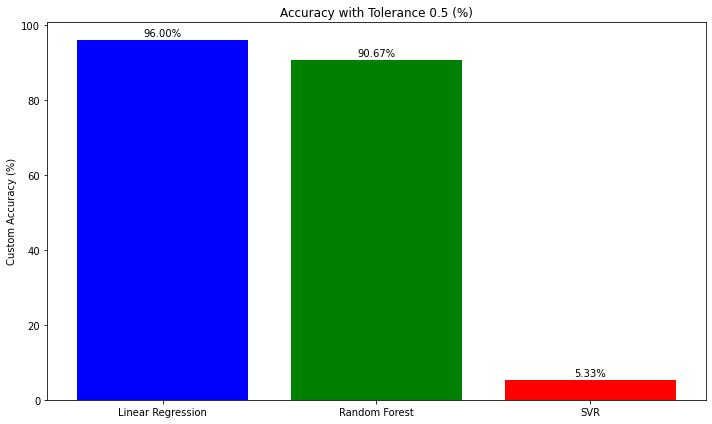

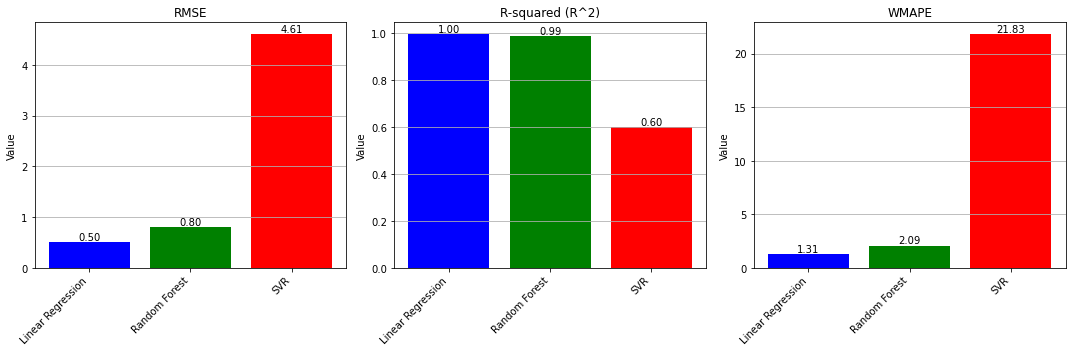

In [11]:
# Calculate custom accuracy for each model
custom_accuracy_linear = custom_accuracy(y_test, linear_model.predict(X_test)) * 100
custom_accuracy_rf = custom_accuracy(y_test, rf_model.predict(X_test)) * 100
custom_accuracy_svr = custom_accuracy(y_test, svr_model.predict(X_test)) * 100

# Create a bar chart to visualize custom accuracy for each model
plt.figure(figsize=(10, 6))
models = ['Linear Regression', 'Random Forest', 'SVR']
custom_accuracies = [custom_accuracy_linear, custom_accuracy_rf, custom_accuracy_svr]
plt.bar(models, custom_accuracies, color=['blue', 'green', 'red'])
plt.title(f'Accuracy with Tolerance {tolerance} (%)')
plt.ylabel('Custom Accuracy (%)')

# Display custom accuracy values on the bars
for i, acc in enumerate(custom_accuracies):
    plt.text(i, acc + 1, f'{acc:.2f}%', ha='center')

plt.tight_layout()

# Define the metrics
metrics = ['RMSE', 'R-squared (R^2)', 'WMAPE']

# Calculate metric values for each model (use the actual values)
metric_values = {
    'Linear Regression': [rmse_linear, r2_linear, wmape_linear],
    'Random Forest': [rmse_rf, r2_rf, wmape_rf],
    'SVR': [rmse_svr, r2_svr, wmape_svr]
}

# Create subplots for each metric
fig, axes = plt.subplots(1, len(metrics), figsize=(15, 5))

for i, metric in enumerate(metrics):
    ax = axes[i]
    model_names = list(metric_values.keys())
    values = [metric_values[model][i] for model in model_names]

    bars = ax.bar(model_names, values, color=['blue', 'green', 'red'])
    ax.set_title(metric)
    ax.set_ylabel('Value')

    # Set tick positions and labels
    ax.set_xticks(np.arange(len(model_names)))
    ax.set_xticklabels(model_names, rotation=45, ha='right')

    ax.grid(axis='y')

    # Add metric values above the bars
    for bar, value in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width() / 2, value, f'{value:.2f}', ha='center', va='bottom')

plt.tight_layout()

# Show the plots
plt.show()

Diagnostic Plots

Durbin-Watson Test Statistic:
Linear Regression: 1.9269122563271592
Random Forest: 2.0084787509324236
Support Vector Regression: 2.5422583907133856


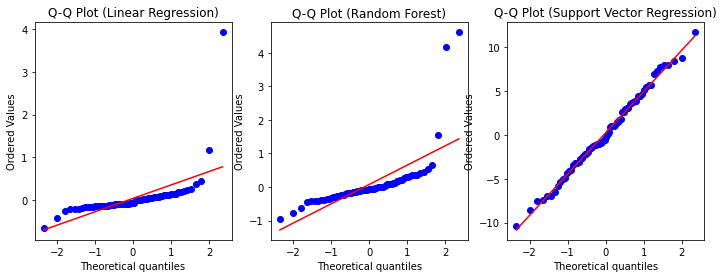

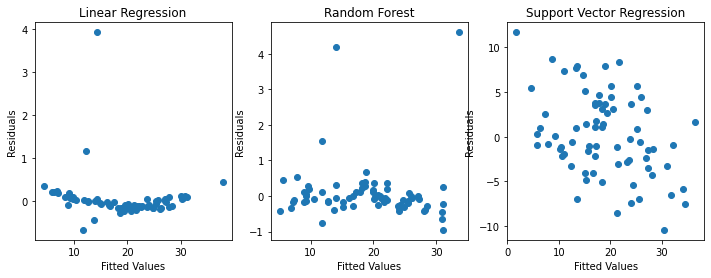

In [12]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats

# Residual Analysis
residuals_linear = y_validation - y_pred_linear
residuals_rf = y_validation - y_pred_rf
residuals_svr = y_validation - y_pred_svr

# Normality of Residuals
plt.figure(figsize=(12, 4))
plt.subplot(131)
stats.probplot(residuals_linear, dist="norm", plot=plt)
plt.title("Q-Q Plot (Linear Regression)")

plt.subplot(132)
stats.probplot(residuals_rf, dist="norm", plot=plt)
plt.title("Q-Q Plot (Random Forest)")

plt.subplot(133)
stats.probplot(residuals_svr, dist="norm", plot=plt)
plt.title("Q-Q Plot (Support Vector Regression)")

# Homoscedasticity
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(y_pred_linear, residuals_linear)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Linear Regression")

plt.subplot(132)
plt.scatter(y_pred_rf, residuals_rf)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Random Forest")

plt.subplot(133)
plt.scatter(y_pred_svr, residuals_svr)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Support Vector Regression")

# Independence of Errors (Durbin-Watson Test)
from statsmodels.stats.stattools import durbin_watson

dw_test_linear = durbin_watson(residuals_linear)
dw_test_rf = durbin_watson(residuals_rf)
dw_test_svr = durbin_watson(residuals_svr)

print("Durbin-Watson Test Statistic:")
print("Linear Regression:", dw_test_linear)
print("Random Forest:", dw_test_rf)
print("Support Vector Regression:", dw_test_svr)

plt.show()